In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.VAE import LinearVAE, MultiLinearVAE, WideAE, LinearAE

In [5]:
encoder1 = nn.Sequential(nn.Linear(28 * 28, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128),
                         nn.ReLU(),
                         nn.Linear(128,64))
decoder1 = nn.Sequential(nn.Linear(1, 8),
                         nn.ReLU(),
                         nn.Linear(8, 16),
                         nn.ReLU(),
                         nn.Linear(16, 32),
                         nn.ReLU(),
                         nn.Linear(32, 64),
                         nn.ReLU(),
                         nn.Linear(64, 128),
                         nn.ReLU(),
                         nn.Linear(128, 256),
                         nn.ReLU(),
                         nn.Linear(256, 28 * 28),
                         nn.Sigmoid())
ae = LinearAE(encoder1, decoder1, 64)

In [3]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

In [23]:
model = ae.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [24]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu = model(data)
            loss = L1Loss(output, data)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), optimizer.param_groups[0]['lr']))
    return allLoss


def test(model, train_loader, epoch):
    model.eval()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            output, mu = model(data)
            loss = BCE(output, data)
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTest loss: {:.6f}'.format(
                epoch, loss.item()))
    return allLoss

In [25]:
for epoch in range(1, 201):
    loss = train(model, train_loader, optimizer, epoch)
    # loss = test(model, test_loader, epoch)
    scheduler.step(np.mean(loss))

 32%|███▏      | 19/59 [00:01<00:03, 11.69batch/s,  Epoch: 8 	Loss: 0.127503	 lr: 0.01000000]


KeyboardInterrupt: 

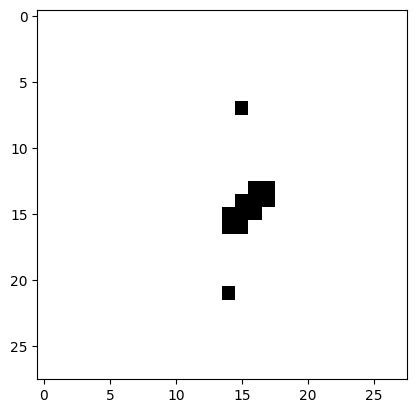

In [26]:
z = torch.normal(0, 1, size=(1, 1)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [27]:
img0 = next(iter(test_loader))[0][0]

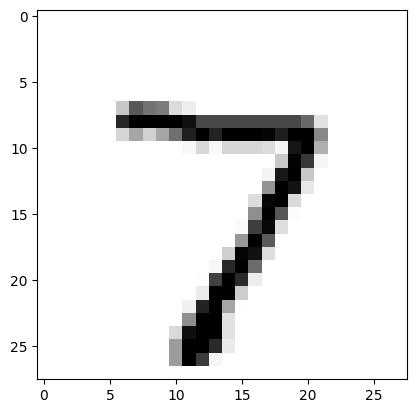

In [28]:
plt.imshow(img0[0], cmap='Greys')

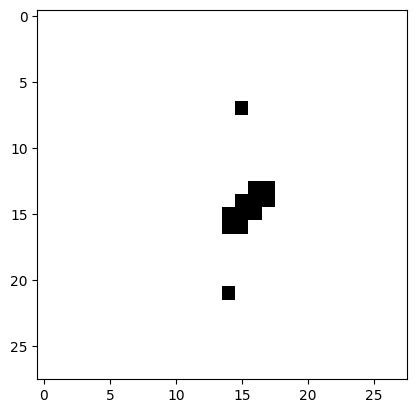

In [29]:
output,_ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

## Cast label into same latent space

In [5]:
encoder2 = nn.Sequential(nn.Linear(28 * 28 + 10, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128),
                         nn.ReLU())
decoder2 = nn.ModuleList([nn.Sequential(nn.Linear(64, 128),
                                        nn.ReLU(),
                                        nn.Linear(128, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, 28 * 28),
                                        nn.Sigmoid()),
                          nn.Sequential(nn.Linear(64, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, 10))])
model = MultiLinearVAE(encoder2, decoder2, 128, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=False, threshold=1e-3)

In [6]:
model.load_state_dict(torch.load('MultiLinearVAE_300epoch_64latent'))

<All keys matched successfully>

In [88]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, label in tEpoch:
            data = data.view(-1, 28 * 28)
            label = nn.functional.one_hot(label).to(torch.float32)
            optimizer.zero_grad()
            output, mu, log_var = model(torch.cat((data, label), -1).cuda())
            reconLoss = BCE(output[0], data.cuda())
            loss = reconLoss + nn.functional.cross_entropy(output[1], label.cuda())
            # loss = reconLoss
            loss.backward()
            optimizer.step()
            allLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.6f}\tRecon Loss :{:.6f} \t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss, optimizer.param_groups[0]['lr']))
    return allLoss


def test(model, train_loader, epoch):
    model.eval()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, label in tEpoch:
            data = data.view(-1, 28 * 28)
            label = nn.functional.one_hot(label).to(torch.float32)
            output, mu, log_var = model(torch.cat((data, label), -1).cuda())
            reconLoss = BCE(output[0], data.cuda())
            loss = reconLoss + nn.functional.cross_entropy(output[1], label.cuda())
            allLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTest Loss: {:.6f}\tRecon Loss :{:.6f}'.format(
                epoch, loss.item(), reconLoss))
    return allLoss

In [89]:
for epoch in range(1, 201):
    _ = train(model, train_loader, optimizer, epoch)
    loss = test(model, test_loader, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 1/1 [00:00<00:00,  1.34batch/s,  Epoch: 200 	Test Loss: 0.139535	Recon Loss :0.122573]


In [90]:
for epoch in range(201, 301):
    _ = train(model, train_loader, optimizer, epoch)
    loss = test(model, test_loader, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 1/1 [00:00<00:00,  1.34batch/s,  Epoch: 300 	Test Loss: 0.128447	Recon Loss :0.114365]


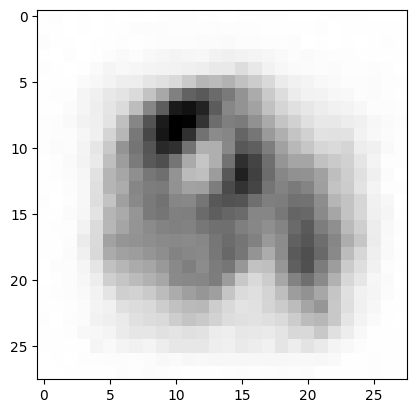

In [93]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z)[0].cpu().detach().view(28, 28), cmap='Greys')

In [7]:
img0 = next(iter(test_loader))[0][0]
label0 = next(iter(test_loader))[1][0]

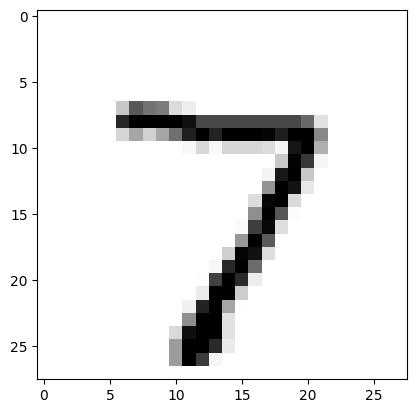

In [8]:
plt.imshow(img0[0], cmap='Greys')

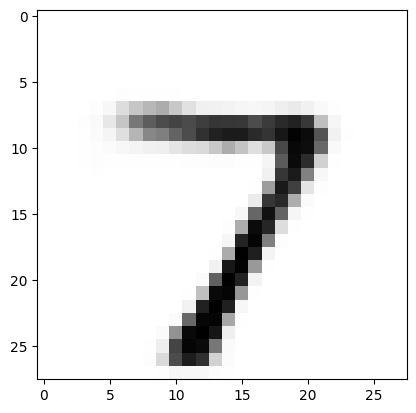

In [9]:
input1 = torch.cat((img0.view(-1, 28 * 28), nn.functional.one_hot(label0, 10).unsqueeze(0)), dim=-1)
output, _, _ = model(input1.cuda())
plt.imshow(output[0].cpu().detach().view(28, 28), cmap='Greys')

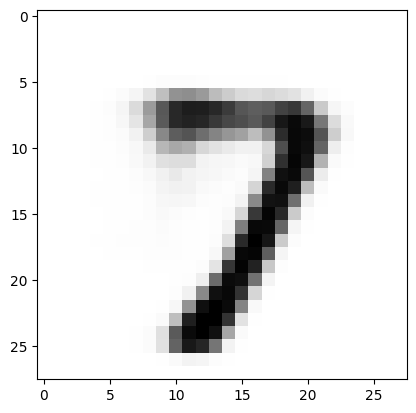

In [10]:
input1 = torch.cat((img0.view(-1, 28 * 28), torch.zeros((1, 10))), dim=-1)
output, _, _ = model(input1.cuda())
plt.imshow(output[0].cpu().detach().view(28, 28), cmap='Greys')

In [97]:
label0

tensor(7)

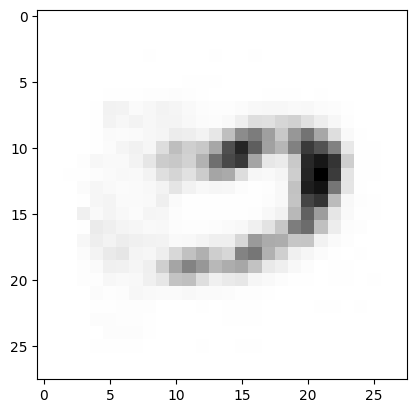

In [98]:
input0 = torch.cat((torch.randn(size=(1, 28 * 28)), nn.functional.one_hot(label0, 10).unsqueeze(0)), dim=-1)
output, _, _ = model(input0.cuda())
plt.imshow(output[0].cpu().detach().view(28, 28), cmap='Greys')

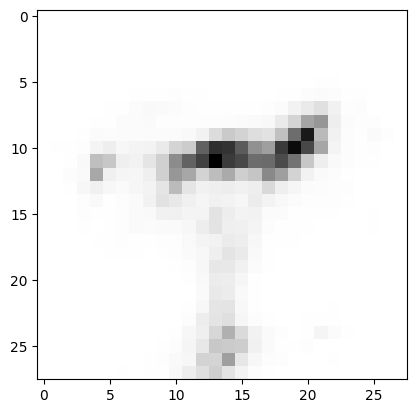

In [100]:
input0 = torch.cat((torch.zeros(size=(1, 28 * 28)), nn.functional.one_hot(label0, 10).unsqueeze(0)), dim=-1)
output, _, _ = model(input0.cuda())
plt.imshow(output[0].cpu().detach().view(28, 28), cmap='Greys')

In [101]:
input2 = torch.cat((img0.view(-1, 28 * 28), torch.zeros(size=(1, 10))), dim=-1)
output, _, _ = model(input0.cuda())
print(output[1])

tensor([[-57.0654, -22.4092, -21.8204, -32.3979, -19.9988, -51.8049, -29.7906,
          17.7246, -10.7889,  -0.5523]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


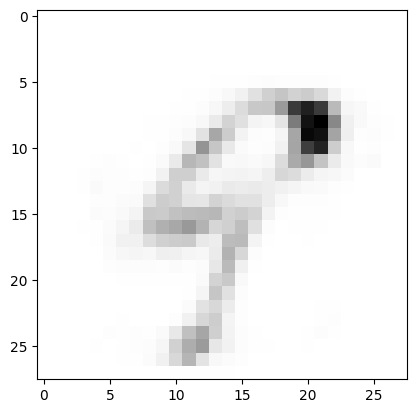

In [112]:
input0 = torch.cat((torch.zeros(size=(1, 28 * 28)), nn.functional.one_hot(torch.tensor(9), 10).unsqueeze(0)), dim=-1)
output, _, _ = model(input0.cuda())
plt.imshow(output[0].cpu().detach().view(28, 28), cmap='Greys')

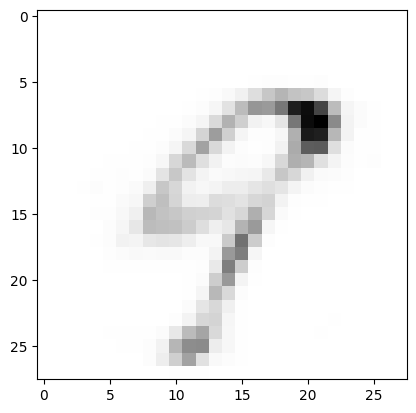

In [113]:
input1 = torch.cat((output[0].cpu(), nn.functional.one_hot(torch.tensor(9), 10).unsqueeze(0)), dim=-1)
outputRecur, _, _ = model(input1.cuda())
plt.imshow(outputRecur[0].cpu().detach().view(28, 28), cmap='Greys')

In [114]:
torch.save(model.state_dict(), 'MultiLinearVAE_300epoch_64latent')

## The distribution of latent space is N(0, 1) we need a network to compute the distribution or ?

In [118]:
encoder2 = nn.Sequential(nn.Linear(28 * 28 + 10, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128),
                         nn.ReLU())
decoder2 = nn.ModuleList([nn.Sequential(nn.Linear(64, 128),
                                        nn.ReLU(),
                                        nn.Linear(128, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, 28 * 28),
                                        nn.Sigmoid()),
                          nn.Sequential(nn.Linear(64, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, 10))])
model = MultiLinearVAE(encoder2, decoder2, 128, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=False, threshold=1e-3)

In [119]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, label in tEpoch:
            data = data.view(-1, 28 * 28)
            label = nn.functional.one_hot(label).to(torch.float32)
            optimizer.zero_grad()
            output, mu, log_var = model(torch.cat((data, label), -1).cuda())
            reconLoss = BCE(output[0], data.cuda())
            loss = reconLoss + nn.functional.cross_entropy(output[1], label.cuda()) + KLD(mu, log_var)
            loss.backward()
            optimizer.step()
            allLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.6f}\tRecon Loss :{:.6f} \t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss, optimizer.param_groups[0]['lr']))
    return allLoss


def test(model, train_loader, epoch):
    model.eval()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, label in tEpoch:
            data = data.view(-1, 28 * 28)
            label = nn.functional.one_hot(label).to(torch.float32)
            output, mu, log_var = model(torch.cat((data, label), -1).cuda())
            reconLoss = BCE(output[0], data.cuda())
            loss = reconLoss + nn.functional.cross_entropy(output[1], label.cuda()) + KLD(mu, log_var)
            allLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTest Loss: {:.6f}\tRecon Loss :{:.6f}'.format(
                epoch, loss.item(), reconLoss))
    return allLoss

In [120]:
for epoch in range(1, 201):
    _ = train(model, train_loader, optimizer, epoch)
    loss = test(model, test_loader, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 1/1 [00:00<00:00,  1.41batch/s,  Epoch: 200 	Test Loss: 0.292741	Recon Loss :0.219055]


In [126]:
torch.normal(torch.zeros((1,)), torch.zeros((1,)))

tensor([0.])

## WideAE

In [13]:
encoderWide = nn.Sequential(nn.Linear(28 * 28, 256),
                            nn.ReLU(),
                            nn.Linear(256, 64),
                            nn.ReLU())
decoderWide = nn.Sequential(nn.Linear(16, 128),
                            nn.ReLU(),
                            nn.Linear(128, 256),
                            nn.ReLU(),
                            nn.Linear(256, 28 * 28),
                            nn.Sigmoid())

model = WideAE(encoderWide, decoderWide, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [14]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            loss = BCE(output, data)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), optimizer.param_groups[0]['lr']))
    return allLoss


def test(model, train_loader, epoch):
    model.eval()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            output, mu, log_var = model(data)
            loss = BCE(output, data)
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTest loss: {:.6f}'.format(
                epoch, loss.item()))
    return allLoss

In [15]:
for epoch in range(1, 201):
    _ = train(model, train_loader, optimizer, epoch)
    loss = test(model, test_loader, epoch)
    scheduler.step(np.mean(loss))

  0%|          | 0/59 [00:03<?, ?batch/s]


RuntimeError: The size of tensor a (16384) must match the size of tensor b (16) at non-singleton dimension 1